In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

def dag(X):
    return X.conj().T

# This function reduces arrays which are only composed by one element to scalars.
def sq(x):
    return np.squeeze(x)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Parameters.
Ω = 1. # Rabi frequency
δ = 0.3 # Dephasing
θ = 0 # Parameter (must be zero to have a linear GKSL evolution)
γR = 1 # Bath coupling strength
γL = 1 # Bath coupling strength
βR = 0.5 # Inverse temperature of the thermal bath
βL = 1 # Inverse temperature of the thermal bath
# TODO: better define the following two parameters
ωR = 1 # Atom transition frequency
ωL = 1 # Atom transition frequency
dt = 0.001
t_max = 10

# Bose-Einstein Nbar calculation (Landi et al. 2023)
NbarR = 1. / (np.exp(-βR * ωR) - 1.)
NbarL = 1. / (np.exp(-βL * ωL) - 1.)

t_range = np.arange(0, t_max, dt)

# Loads Pauli matrices.
σx = np.array([[0,1],[1,0]], dtype="complex128")
σy = np.array([[0, -1j],[1j,0]], dtype="complex128")
σz = np.array([[1,0],[0,-1]], dtype="complex128")

# And raising and lowering operators.
σp = np.array([[0,0],[1,0]], dtype="complex128")
σm = dag(σp)

# And the identity matrix.
ide = np.array([[1,0],[0,1]], dtype="complex128")
# And the zero matrix
zero = np.array([[0,0],[0,0]], dtype="complex128")

L_Rin = NbarR * γR * σp
L_Rout = (NbarR + 1) * γR * σm
L_Lin = NbarL * γL * σp
L_Lout = (NbarL + 1) * γL * σm

H = Ω * σx + δ * σz

In [7]:
def execute_step(ψ0, ϕ0, S0, print_jumps=False):
    # Note that this uses the SSE (not the SME) version of the stochastic evolution of the monitoring vector (see Albarelli et al. 2018).
    ρ = ψ0 @ dag(ψ0)
    
    # Computes the value of H in the perturbative dynamics.
    Hθ = (1 + θ) * H
    
    # Computes the value of the jump operators coefficients in the perturbative dynamics.
    l_Rin = (np.trace(L_Rin @ ρ @ dag(L_Rin)) - np.trace(L_Rout @ ρ @ dag(L_Rout))) / (np.trace(L_Rin @ ρ @ dag(L_Rin)) + np.trace(L_Rout @ ρ @ dag(L_Rout)))
    l_Rout = - l_Rin
    l_Lin = (np.trace(L_Lin @ ρ @ dag(L_Lin)) - np.trace(L_Lout @ ρ @ dag(L_Lout))) / (np.trace(L_Lin @ ρ @ dag(L_Lin)) + np.trace(L_Lout @ ρ @ dag(L_Lout)))
    l_Lout = - l_Lin
    
    # Computes the jump operators.
    Lθ_Rin = np.sqrt(1 + l_Rin * θ) * L_Rin
    Lθ_Rout = np.sqrt(1 + l_Rout * θ) * L_Rout
    Lθ_Lin = np.sqrt(1 + l_Lin * θ) * L_Lin
    Lθ_Lout = np.sqrt(1 + l_Lout * θ) * L_Lout
    
    # Overall jump operator.
    J = dag(Lθ_Rin) @ Lθ_Rin + dag(Lθ_Rout) @ Lθ_Rout + dag(Lθ_Lin) @ Lθ_Lin + dag(Lθ_Lout) @ Lθ_Lout
    
    # Effective Hamiltonian.
    Heff = Hθ - 1j/2. * J
    
    # Kraus operators for infinitesimal time evolution.
    V_0 = ide - 1j * Heff * dt
    V_Rin = Lθ_Rin * np.sqrt(dt)
    V_Rout = Lθ_Rout * np.sqrt(dt)
    V_Lin = Lθ_Lin * np.sqrt(dt)
    V_Lout = Lθ_Lout * np.sqrt(dt)
    
    # Derivatives of the Kraus operators for the FI evolution with respect to θ.
    dV_0 = - 1j * (H - 1j/2. * (l_Rin * dag(L_Rin) @ L_Rin + l_Rout * dag(L_Rout) @ L_Rout + l_Lin * dag(L_Lin) @ L_Lin + l_Lout * dag(L_Lout) @ L_Lout)) * dt
    dV_Rin = l_Rin / (2 * np.sqrt(1 + l_Rin * θ)) * L_Rin * np.sqrt(dt)
    dV_Rout = l_Rout / (2 * np.sqrt(1 + l_Rout * θ)) * L_Rout * np.sqrt(dt)
    dV_Lin = l_Lin / (2 * np.sqrt(1 + l_Lin * θ)) * L_Lin * np.sqrt(dt)
    dV_Lout = l_Lout / (2 * np.sqrt(1 + l_Lout * θ)) * L_Lout * np.sqrt(dt)
    
    # Corresponding probabilities.
    p_Rin = np.real(dag(ψ0) @ dag(V_Rin) @ V_Rin @ ψ0)[0][0]
    p_Rout = np.real(dag(ψ0) @ dag(V_Rout) @ V_Rout @ ψ0)[0][0]
    p_Lin = np.real(dag(ψ0) @ dag(V_Lin) @ V_Lin @ ψ0)[0][0]
    p_Lout = np.real(dag(ψ0) @ dag(V_Lout) @ V_Lout @ ψ0)[0][0]
    
    # p_0 is defined in order to guarantee normalisation.
    p_0 = 1 - (p_Rin + p_Rout + p_Lin + p_Lout)
    
    # Chooses the Kraus operator to apply.
    t_V = np.random.choice(["V_0", "V_Rin", "V_Rout", "V_Lin", "V_Lout"], p=[p_0, p_Rin, p_Rout, p_Lin, p_Lout])
    
    # Lookup tables for conversion to proper operator, and to its derivative.
    dict_V = {"V_0": V_0, "V_Rin": V_Rin, "V_Rout": V_Rout, "V_Lin": V_Lin, "V_Lout": V_Lout}
    dict_dV = {"V_0": dV_0, "V_Rin": dV_Rin, "V_Rout": dV_Rout, "V_Lin": dV_Lin, "V_Lout": dV_Lout}
    V = dict_V[t_V]
    dV = dict_dV[t_V]
        
    if print_jumps and not (t_V == "V_0"):
        print(f"Jump in channel {t_V}")
        print(f"Probabilities were p_0={p_0}  p_Rin={p_Rin}  p_Rout={p_Rout}  p_Lin={p_Lin}  p_Lout={p_Lout}")
    
    # If a jump has happened, updates the accumulator of irreversible entropy produced so far.
    if t_V == "V_Rin":
        S = S0 + np.real(l_Rin)**2
    elif t_V == "V_Rout":
        S = S0 + np.real(l_Rout)**2
    elif t_V == "V_Lin":
        S = S0 + np.real(l_Lin)**2
    elif t_V == "V_Lout":
        S = S0 + np.real(l_Lout)**2
    else:
        S = S0 # No entropy production for coherent evolution only.
        
    
    # Updates the state.
    ψ = V @ ψ0 / np.linalg.norm(V @ ψ0)
    
    # Updates the two monitoring operators.
    ϕ = (dV @ ψ0 + V @ ϕ0) / np.linalg.norm(V @ ψ0)
    
    return ψ, ϕ, S

# Single trajectory experiments

In [8]:
v_exp_σz = []
v_stoch_entropy = []
v_stoch_f = []

# Initial settings.
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕ0 = np.array([[0],[0]], dtype="complex128")
S0 = 0

ψ = ψ0
ϕ = ϕ0
S = S0
for t in t_range:
    ψ, ϕ, S = execute_step(ψ, ϕ, S, True)
    exp_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
    stoch_entropy = S
    stoch_f = sq(np.real(dag(ψ) @ ϕ + dag(ϕ) @ ψ))**2
    
    v_exp_σz.append(exp_σz)
    v_stoch_entropy.append(stoch_entropy)
    v_stoch_f.append(stoch_f)

Jump in channel V_Rin
Probabilities were p_0=0.9910635337713033  p_Rin=0.006432953726052211  p_Rout=9.652584674130511e-06  p_Lin=0.002492484067927589  p_Lout=1.3758500427410732e-06
Jump in channel V_Lout
Probabilities were p_0=0.9970920099762917  p_Rin=0.0001996496654181746  p_Rout=0.002302756999151862  p_Lin=7.735538469779366e-05  p_Lout=0.0003282279744405127
Jump in channel V_Rin
Probabilities were p_0=0.9913994996175338  p_Rin=0.00608557286191111  p_Rout=0.0001374468628480105  p_Lin=0.0023578894001829533  p_Lout=1.9591257524098962e-05
Jump in channel V_Rin
Probabilities were p_0=0.9967327250049588  p_Rin=0.0005711419620753463  p_Rout=0.0021660926206581253  p_Lin=0.0002212921624529264  p_Lout=0.00030874824985485644
Jump in channel V_Rout
Probabilities were p_0=0.9971199053058292  p_Rin=0.0001708065440444778  p_Rout=0.0023133677905244573  p_Lin=6.617995525204832e-05  p_Lout=0.00032974040434984356
Jump in channel V_Lin
Probabilities were p_0=0.9910495599288415  p_Rin=0.0064474023538643

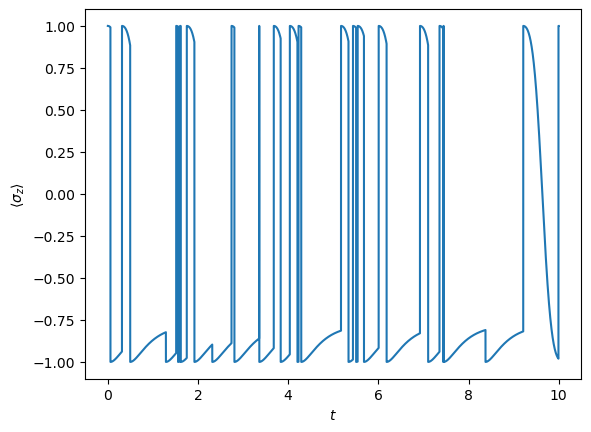

In [9]:
plt.plot(t_range, v_exp_σz)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.show()

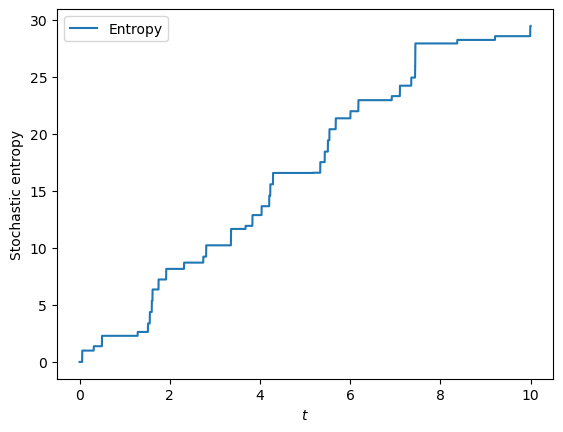

In [12]:
plt.plot(t_range, v_stoch_entropy, label="Entropy")
plt.xlabel("$t$")
plt.ylabel("Stochastic entropy")
plt.legend()
plt.show()

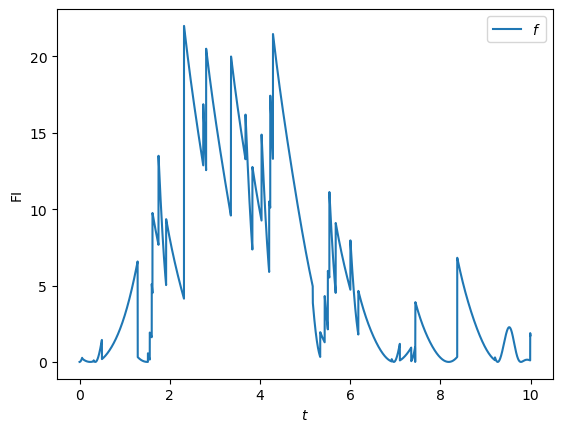

In [13]:
plt.plot(t_range, v_stoch_f, label="$f$")
plt.xlabel("$t$")
plt.ylabel("FI")
plt.legend()
plt.show()

# Average over multiple trajectories

In [ ]:
number_trajectories = 500

v_ave_exp_σz = np.zeros(len(t_range))
v_ave_entropy = np.zeros(len(t_range))
v_ave_f = np.zeros(len(t_range))

# Initial settings.
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕ0 = np.array([[0],[0]], dtype="complex128")
S0 = 0

for trajectory in range(number_trajectories):
    ψ = ψ0
    ϕ = ϕ0
    S = S0
    for n_t, t in enumerate(t_range):
        ψ, ϕ, S = execute_step(ψ, ϕ, S)
        exp_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
        stoch_entropy = S
        stoch_f = sq(np.real(dag(ψ) @ ϕ + dag(ϕ) @ ψ))**2

        v_ave_exp_σz[n_t] += exp_σz / number_trajectories 
        v_ave_entropy[n_t] += stoch_entropy / number_trajectories
        v_ave_f[n_t] += stoch_f / number_trajectories
        
    print(f"Completed for trajectory {trajectory}")

Completed for trajectory 0
Completed for trajectory 1
Completed for trajectory 2


In [ ]:
plt.plot(t_range, v_ave_exp_σz)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.show()

In [ ]:
plt.plot(t_range, v_ave_entropy, label="Entropy")
plt.xlabel("$t$")
plt.ylabel("Entropy")
plt.legend()
plt.show()

In [ ]:
plt.plot(t_range, v_ave_f, label="$f$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("FI")
plt.show()

In [ ]:
v_Q = v_ave_f - v_ave_entropy

In [ ]:
plt.plot(t_range, v_Q, label="$\mathcal{Q}$")
plt.xlabel("$t$")
plt.ylabel("$\mathcal{Q}$")
plt.legend()
plt.show()